# Lab 8

## Melissa Tobias

## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

In [3]:
pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [4]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [5]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [6]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

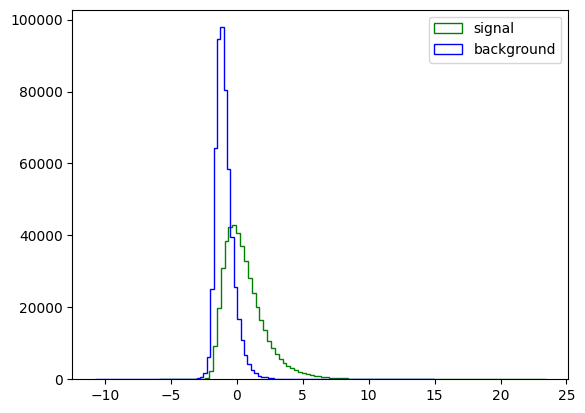

In [7]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="green", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="blue", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

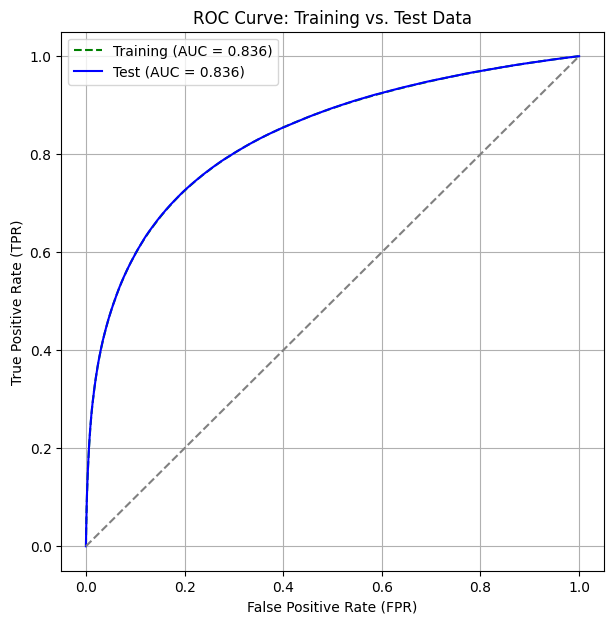

In [8]:
#part a

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    
    #computing decision function
    y_train_scores=model.decision_function(X_train)
    y_test_scores=model.decision_function(X_test)

    #computing ROC curve
    fpr_train, tpr_train, _=roc_curve(y_train, y_train_scores)
    fpr_test, tpr_test, _=roc_curve(y_test, y_test_scores)

    auc_train=auc(fpr_train, tpr_train)
    auc_test=auc(fpr_test, tpr_test)

    #plotting
    plt.figure(figsize=(7, 7))
    plt.plot(fpr_train, tpr_train, label=f"Training (AUC = {auc_train:.3f})", linestyle='--', color='green')
    plt.plot(fpr_test, tpr_test, label=f"Test (AUC = {auc_test:.3f})", linestyle='-', color='blue')
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve: Training vs. Test Data")
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curve(Fisher, X_Train, y_Train, X_Test, y_Test)

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

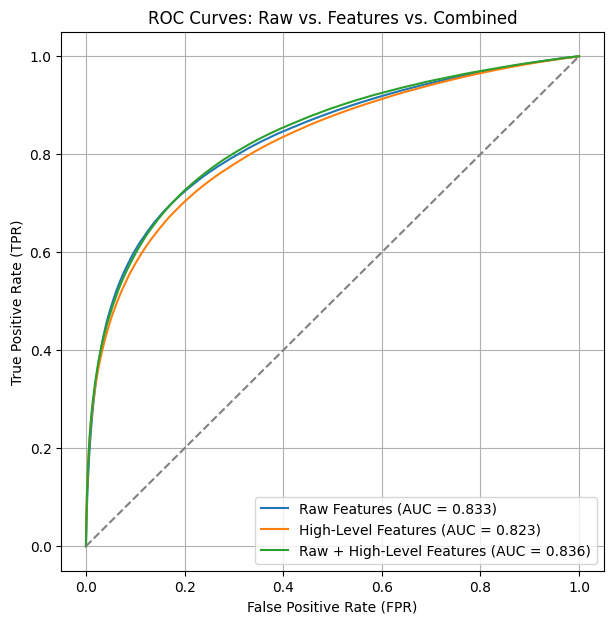

In [9]:
#part b

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

RawNames=["l_1_pT", "l_1_eta", "l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames=list(set(VarNames[1:]) - set(RawNames))
AllFeatures=VarNames[1:]

N_Train=4000000

def train_and_plot_roc(df, feature_sets):
    plt.figure(figsize=(7, 7))

    for name, features in feature_sets.items():
        X_train=df[:N_Train][features]
        y_train=df[:N_Train]["signal"]
        X_test=df[N_Train:][features]
        y_test=df[N_Train:]["signal"]

        model=LinearDiscriminantAnalysis()
        model.fit(X_train, y_train)

        y_scores=model.decision_function(X_test)
        fpr, tpr, _=roc_curve(y_test, y_scores)
        roc_auc=auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curves: Raw vs. Features vs. Combined")
    plt.legend()
    plt.grid()
    plt.show()

feature_sets={
    "Raw Features": RawNames,
    "High-Level Features": FeatureNames,
    "Raw + High-Level Features": AllFeatures
}

train_and_plot_roc(df, feature_sets)

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

In [10]:
#part a

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#part b

def compare_model_features(model, df, N_Train=4000000):
    RawNames=["l_1_pT", "l_1_eta", "l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
    FeatureNames=list(set(VarNames[1:]) - set(RawNames))
    AllFeatures=VarNames[1:]

    feature_sets={
        "Raw Features": RawNames,
        "High-Level Features": FeatureNames,
        "Raw + High-Level": AllFeatures
    }

    plt.figure(figsize=(7, 7))

    for name, features in feature_sets.items():
        X_train=df[:N_Train][features]
        y_train=df[:N_Train]["signal"]
        X_test=df[N_Train:][features]
        y_test=df[N_Train:]["signal"]

        clf=model 
        clf.fit(X_train, y_train)
        y_scores=clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)

        fpr, tpr, _=roc_curve(y_test, y_scores)
        roc_auc=auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Comparison: {model.__class__.__name__}")
    plt.grid()
    plt.show()

compare_model_features(LogisticRegression(solver='liblinear'), df)
compare_model_features(DecisionTreeClassifier(max_depth=5), df)
compare_model_features(KNeighborsClassifier(n_neighbors=5), df)

In [ ]:
#part c

def compute_max_significance(model, df, features, N_Train=4000000):
    Train=df[:N_Train]
    Test=df[N_Train:]

    X_train=Train[features]
    y_train=Train["signal"]
    X_test=Test[features]
    y_test=Test["signal"]

    model.fit(X_train, y_train)

    scores=model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    best_sigma=0
    best_threshold=0
    for t in np.linspace(0, 1, 200):
        selected=scores>t
        N_S=np.sum((selected) & (y_test==1))
        N_B=np.sum((selected) & (y_test==0))
        if N_S+N_B>0:
            sigma=N_S/np.sqrt(N_S+N_B)
            if sigma>best_sigma:
                best_sigma=sigma
                best_threshold=t

    print(f"Max significance: σ_S = {best_sigma:.2f} at threshold = {best_threshold:.2f}")
    return best_sigma, best_threshold

best_model=LogisticRegression(solver='liblinear')
best_features=VarNames[1:]
compute_max_significance(best_model, df, best_features)

### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

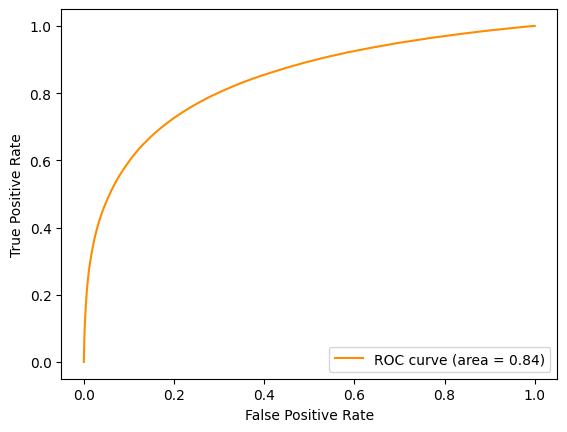

In [11]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _=roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc=auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


In [ ]:
#part b

from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

def compute_metrics(model, X_test, y_test):
    y_scores=model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)[:, 1]

    fpr, tpr, _=roc_curve(y_test, y_scores)
    roc_auc=auc(fpr, tpr)

    threshold=0.5
    y_pred=(y_scores>=threshold).astype(int)

    precision=precision_score(y_test, y_pred)
    recall=recall_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)

    N_S=np.sum((y_pred==1) & (y_test==1))
    N_B=np.sum((y_pred==1) & (y_test==0))
    significance=N_S/np.sqrt(N_S+N_B) if (N_S+N_B)>0 else 0

    return {
        "AUC": roc_auc,
        "Precision": precision,
        "Recall (TPR)": recall,
        "FPR": fpr[1],
        "F1 Score": f1,
        "Accuracy": accuracy,
        "Max Significance (σ_S)": significance
    }
    
best_model=RandomForestClassifier(n_estimators=100)
X_train=df[:N_Train][AllFeatures]
y_train=df[:N_Train]["signal"]
X_test=df[N_Train:][AllFeatures]
y_test=df[N_Train:]["signal"]

best_model.fit(X_train, y_train)
metrics=compute_metrics(best_model, X_test, y_test)
metrics_df=pd.DataFrame([metrics])
display(metrics_df)